# Análise de Tendências Globais do Cinema e Séries entre 2015 e 2025

   <img src="https://static.vecteezy.com/ti/vetor-gratis/p1/21850617-realista-cinema-poster-vetor.jpg" width="2000" height="300">

*Banner projetado por [MacroVector](https://br.freepik.com/vetores-gratis/cartaz-de-tempo-de-filme-de-cinema-horizontal-realista-com-carretel-de-badalo-de-bilhetes-de-lanches-de-oculos-3d-em-fundo-azul-com-ilustracao-vetorial-bokeh_33770857.htm#from_element=cross_selling__vector)*

**Integrantes:**
> ***Lucas Vinicius de Sousa Lima Ivo***
<br>
> ***Carlos Eugênio de Sousa Machado***
<br>
> ***Renato de Abreu valverde Silva***
<br>
> ***Marcelo Lira Medeiros***
<br>
> ***Matheus Rodrigues Da Silva Leite***
<br>
> ***Glênyo Allan Martins Muniz***
<br>


# 1 - Problematização

O entretenimento audiovisual passou por grandes transformações na última década, impulsionadas pela expansão do streaming e mudanças nos hábitos de consumo. Compreender a dinâmica desse mercado é essencial para analisar a evolução da indústria.

Este projeto busca analisar as tendências globais do cinema e das séries entre 2015 e 2025 a partir de dados do IMDb. O objetivo é identificar padrões e transformações em aspectos como:

- **Volume de Produção:** Como o número de lançamentos por tipo de título (filme, série, minissérie) evoluiu ao longo dos anos.
- **Popularidade de Gêneros:** Quais gêneros dominaram o mercado e se houve mudanças na preferência do público.
- **Qualidade Percebida:** A variação da média de avaliação dos títulos ao longo do tempo e sua relação com o número de votos.
- **Características das Produções:** Análise da duração média dos títulos por gênero.
- **Participação de Talentos:** Identificação dos diretores e atores mais ativos no período.

Em suma, a análise busca responder à seguinte questão: **Quais foram as principais tendências e transformações na produção e recepção do cinema e das séries globais entre 2015 e 2025, segundo os dados disponíveis?** Os insights gerados podem ser valiosos para entender o cenário atual e futuro da indústria audiovisual.


# 2 - Fonte de Dados

**IMDb Datasets (licença não-comercial):** https://developer.imdb.com/non-commercial-datasets/

### Arquivos utilizados:
- `title.basics.tsv`
- `title.ratings.tsv`
- `name.basics.tsv`
- `title.principals.tsv`


# 3 - Aquisição e Pré-Tratamento dos Dados

Devido ao tamanho dos arquivos (.tsv), o pré-processamento foi realizado localmente. As etapas incluíram:
- Filtro de títulos entre 2015 e 2025
- Seleção de filmes, séries e minisséries
- Conversão de colunas numéricas
- Junção com avaliações e votos
- Extração de diretores e atores recorrentes

O resultado final foi salvo em um arquivo CSV:
`imdb_refinado.csv`

Logo abaixo você pode conferir o codigo utilizado para gerar o arquivo CSV **`Não tente rodar esse codigo`**


In [ ]:
import pandas as pd

# Caminho dos arquivos IMDb
path_basics = "title.basics.tsv"
path_ratings = "title.ratings.tsv"
path_principals = "title.principals.tsv"
path_names = "name.basics.tsv"

# --------------------------
# 1. Carregar e processar title.basics
# --------------------------
print("Carregando title.basics.tsv.gz...")
df_basics = pd.read_csv(path_basics, sep='\t', dtype=str, na_values='\\N')

# Filtrar tipos desejados
tipos_desejados = ['movie', 'tvSeries', 'tvMiniSeries']
df_basics = df_basics[df_basics['titleType'].isin(tipos_desejados)]

# Filtrar ano entre 2015 e 2025
df_basics = df_basics[df_basics['startYear'].notna()]
df_basics['startYear'] = pd.to_numeric(df_basics['startYear'], errors='coerce')
df_basics = df_basics[(df_basics['startYear'] >= 2015) & (df_basics['startYear'] <= 2025)]

# Tratar duração
df_basics['runtimeMinutes'] = pd.to_numeric(df_basics['runtimeMinutes'], errors='coerce')
df_basics = df_basics[df_basics['runtimeMinutes'].notna() & (df_basics['runtimeMinutes'] > 0)]

# Gêneros
df_basics['genres'] = df_basics['genres'].fillna('Desconhecido')

# --------------------------
# 2. Carregar e unir com ratings
# --------------------------
print("Carregando title.ratings.tsv.gz...")
df_ratings = pd.read_csv(path_ratings, sep='\t', dtype={'tconst': str})
df_ratings['averageRating'] = pd.to_numeric(df_ratings['averageRating'], errors='coerce')
df_ratings['numVotes'] = pd.to_numeric(df_ratings['numVotes'], errors='coerce')

# Merge
print("Unindo basics + ratings...")
df_merged = pd.merge(df_basics, df_ratings, on='tconst', how='inner')

# --------------------------
# 3. Carregar e filtrar principals (atores/diretores)
# --------------------------
print("Carregando title.principals.tsv.gz...")
df_principals = pd.read_csv(path_principals, sep='\t', dtype=str, na_values='\\N')

# Filtrar apenas os títulos presentes no dataset já refinado
df_principals = df_principals[df_principals['tconst'].isin(df_merged['tconst'])]

# Filtrar apenas atores e diretores
df_principals = df_principals[df_principals['category'].isin(['actor', 'actress', 'director'])]

# --------------------------
# 4. Carregar nomes
# --------------------------
print("Carregando name.basics.tsv.gz...")
df_names = pd.read_csv(path_names, sep='\t', dtype=str, na_values='\\N')
df_names = df_names[['nconst', 'primaryName']]

# Merge com os nomes reais
print("Unindo com nomes das pessoas...")
df_people = pd.merge(df_principals, df_names, on='nconst', how='left')

# Agrupar os envolvidos por título (lista de nomes por tipo)
print("Agrupando atores e diretores por título...")
df_actors = df_people[df_people['category'].isin(['actor', 'actress'])].groupby('tconst')['primaryName'].apply(list).reset_index(name='atores')
df_directors = df_people[df_people['category'] == 'director'].groupby('tconst')['primaryName'].apply(list).reset_index(name='diretores')

# Unir com dataset final
print("Unindo atores e diretores ao dataset final...")
df_final = df_merged.merge(df_actors, on='tconst', how='left').merge(df_directors, on='tconst', how='left')

# --------------------------
# 5. Selecionar e salvar
# --------------------------
df_final = df_final[['tconst', 'titleType', 'primaryTitle', 'startYear', 'runtimeMinutes',
                     'genres', 'averageRating', 'numVotes', 'atores', 'diretores']]

print("Salvando imdb_refinado.csv...")
df_final.to_csv("imdb_refinado.csv", index=False)

print(f"Concluído! Dataset salvo com {len(df_final)} registros.")


# 4 - Carregamento do dataset pré-tratado

In [ ]:
import pandas as pd

# Carregando o dataset já pré-processado
df = pd.read_csv("https://raw.githubusercontent.com/lucasviniz/mv-process/main/imdb_refinado.csv")

# Visualizando as primeiras linhas
df.head()

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,atores,diretores
0,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,2020,70.0,Drama,6.4,229,"['Rubén Sotoconil', 'Claudia Paz', 'Luis Alarc...","['Raúl Ruiz', 'Valeria Sarmiento']"
1,tt0069049,movie,The Other Side of the Wind,2018,122.0,Drama,6.7,8271,"['John Huston', 'Oja Kodar', 'Peter Bogdanovic...",['Orson Welles']
2,tt0070596,movie,Socialist Realism,2023,78.0,"Drama,History",7.1,139,"['Nemesio Antúnez', 'Marcial Edwards', 'Colect...","['Raúl Ruiz', 'Valeria Sarmiento']"
3,tt0093119,movie,Grizzly II: Revenge,2020,74.0,"Horror,Music,Thriller",2.7,1832,"['George Clooney', 'Laura Dern', 'Charlie Shee...",['André Szöts']
4,tt0097767,movie,Loading Ludwig,2022,65.0,Desconhecido,7.0,6,['Mara Mattuschka'],['Mara Mattuschka']


# 5 - Limpeza dos Dados

Nesta seção faremos a limpeza efetiva dos dados, lidando com valores ausentes, tipos incorretos e consistência dos campos.

### a. Preparação para a Limpeza

Vamos padronizar valores ausentes e observar onde ocorrem problemas.

In [ ]:
# Substituir strings vazias ou nulas por NaN
import numpy as np

valores_invalidos = ['\\N', 'NA', '', '[]']
df.replace(valores_invalidos, np.nan, inplace=True)

In [ ]:
# Verificar valores ausentes por coluna
df.isnull().sum()

,0
tconst,0
titleType,0
primaryTitle,0
startYear,0
runtimeMinutes,0
genres,0
averageRating,0
numVotes,0
atores,22749
diretores,25891


### b. Conversão de Dados

Aqui ajustamos os tipos das colunas que serão utilizadas nas análises.

In [ ]:
# Conversão dos tipos principais
df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce')
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')
df['averageRating'] = pd.to_numeric(df['averageRating'], errors='coerce')
df['numVotes'] = pd.to_numeric(df['numVotes'], errors='coerce')

### c. Visualização da Qualidade dos Dados

Vamos utilizar a biblioteca `missingno` para visualizar graficamente os dados ausentes.

In [ ]:
!pip install -q missingno

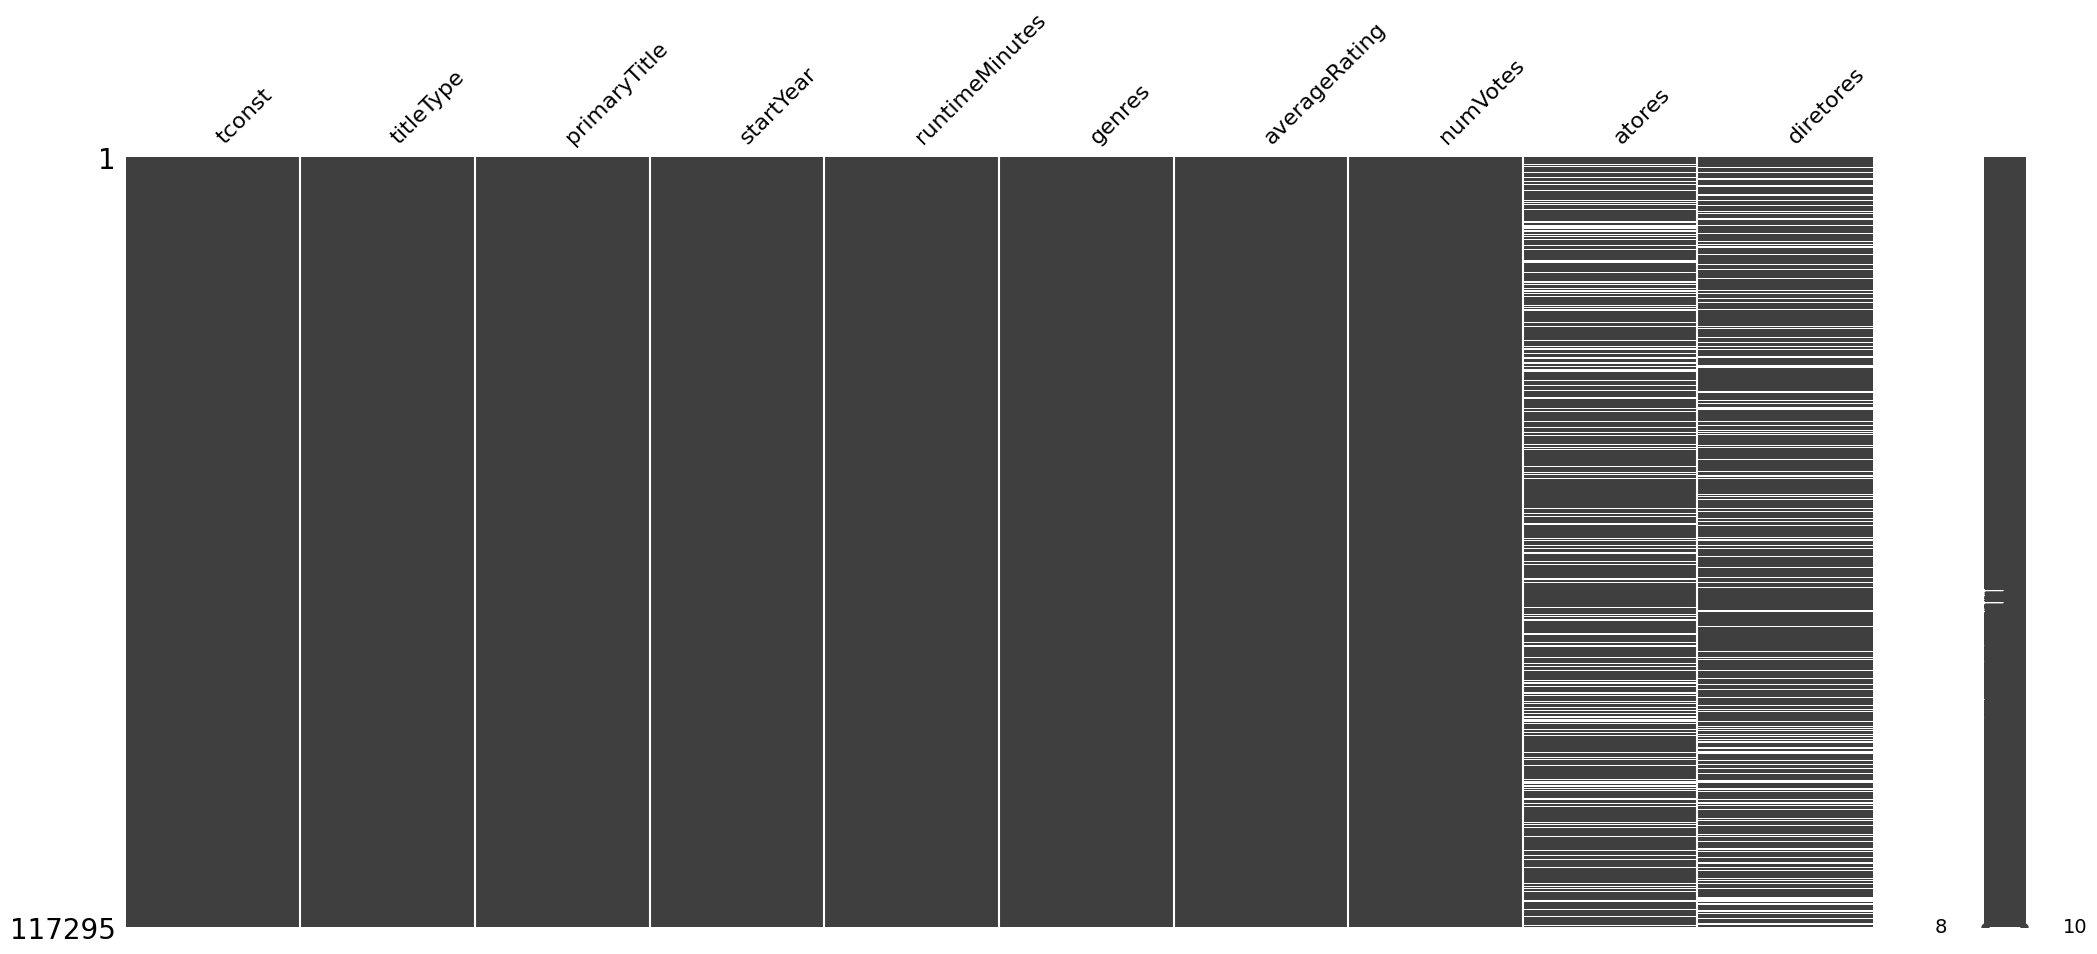

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualizar valores ausentes
msno.matrix(df)
plt.show()

### d. Limpeza Final

Agora vamos decidir como tratar os dados ausentes identificados.

In [ ]:
# Remover registros com campos essenciais ausentes
df.dropna(subset=['startYear', 'runtimeMinutes', 'averageRating', 'numVotes'], inplace=True)

In [ ]:
import ast

# Converter as colunas de string para listas, tratando valores nulos e formatos inesperados com segurança
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x) if pd.notnull(x) else []
    except (SyntaxError, ValueError):
        return [x] if pd.notnull(x) else []

df['atores'] = df['atores'].apply(safe_literal_eval)
df['diretores'] = df['diretores'].apply(safe_literal_eval)

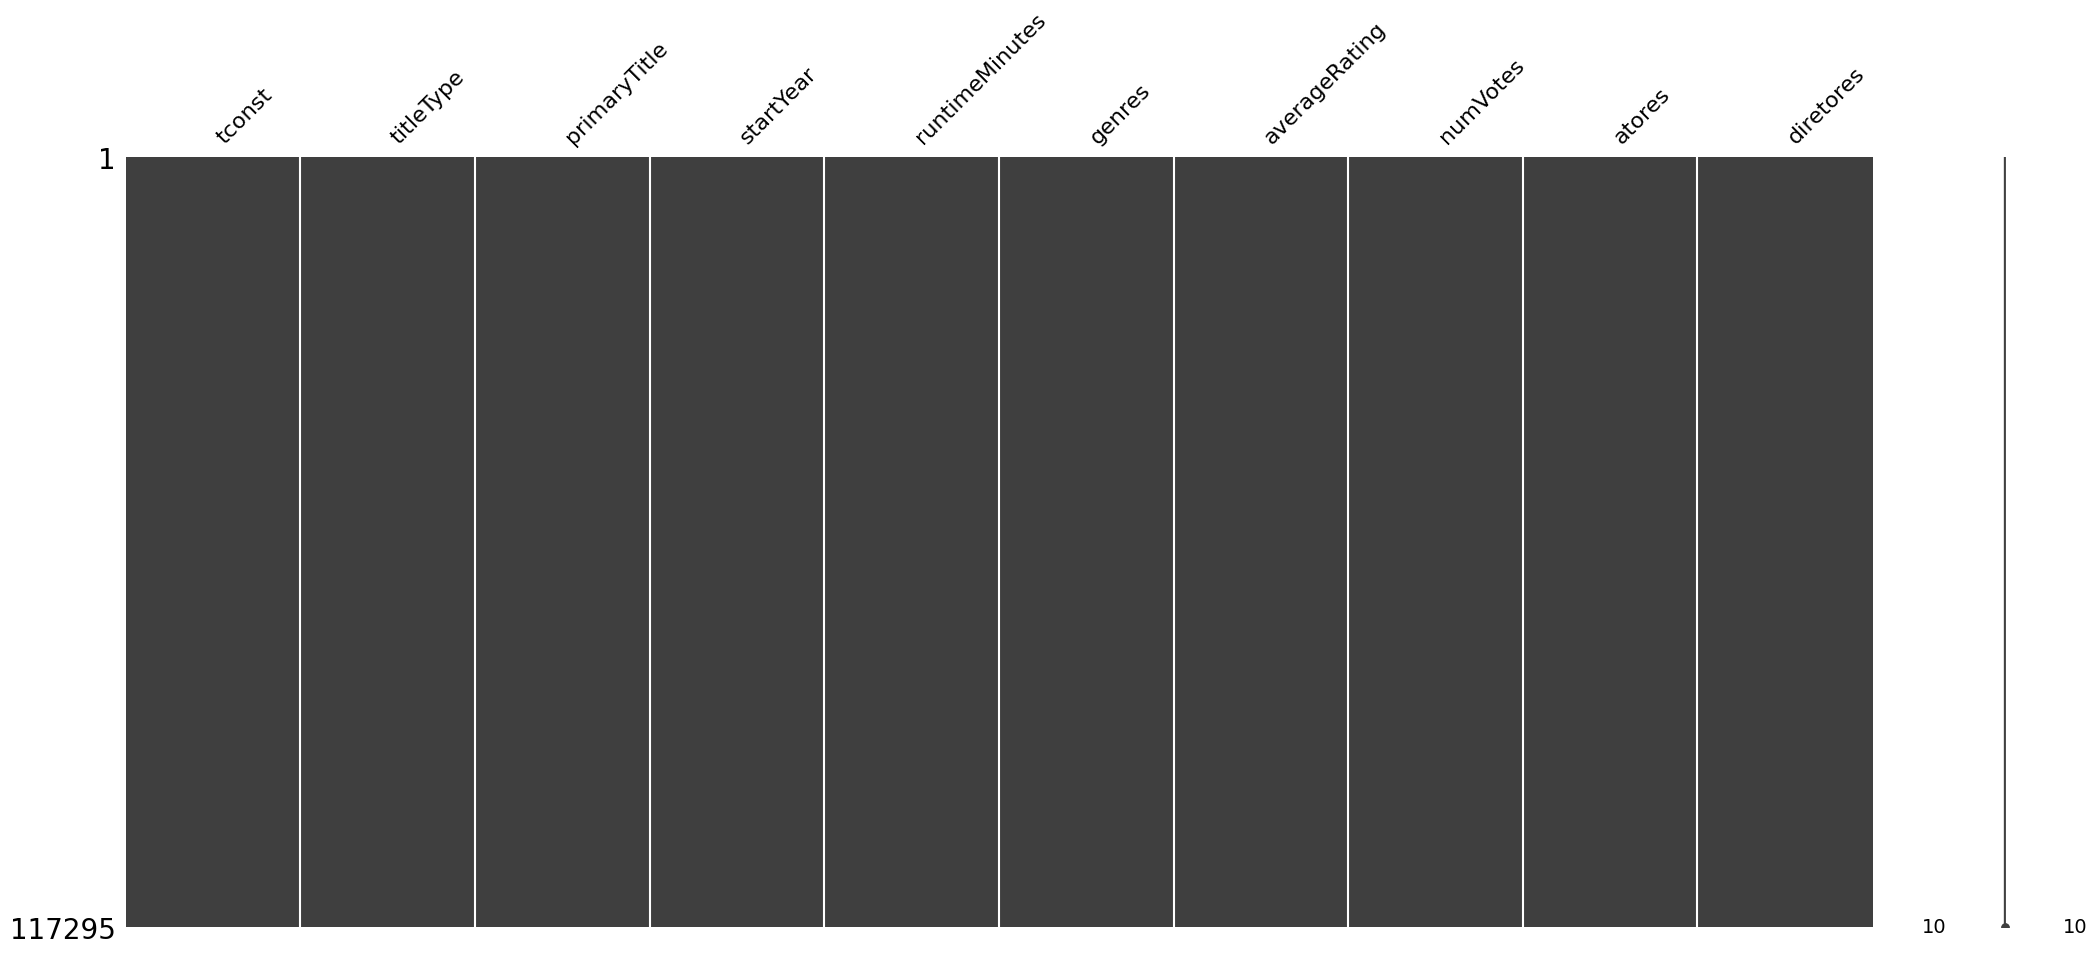

In [ ]:
# Verificar dimensões finais do dataset
df.shape

msno.matrix(df)
plt.show()

# 6 - Análise dos Dados

Nesta seção, exploraremos visualmente os dados para identificar padrões, tendências e insights sobre o cinema e as séries globais entre 2015 e 2025.

### 6.1 Número de lançamentos por ano e tipo de título

Vamos visualizar a quantidade de lançamentos por ano no período de 2015 a 2025, separados por tipo de título (filmes, séries e minisséries). Essa visualização serve como base para compreendermos o volume de produções ao longo dos anos.

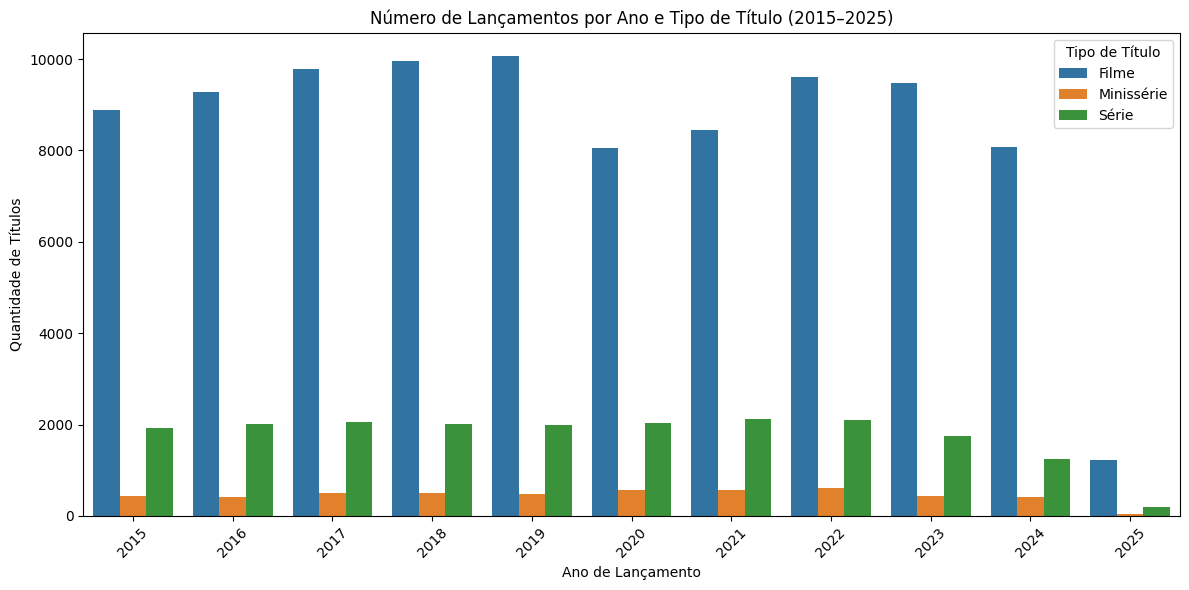

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Traduzir os tipos para português
df_traduzido = df.copy()
df_traduzido['titleType'] = df_traduzido['titleType'].replace({
    'movie': 'Filme',
    'tvSeries': 'Série',
    'tvMiniSeries': 'Minissérie'
})

# Reagrupar os dados
df_grouped = df_traduzido.groupby(['startYear', 'titleType']).size().reset_index(name='count')

# Plotar gráfico com rótulos em português
plt.figure(figsize=(12, 6))
sns.barplot(data=df_grouped, x='startYear', y='count', hue='titleType')
plt.title('Número de Lançamentos por Ano e Tipo de Título (2015–2025)')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Quantidade de Títulos')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Título')
plt.tight_layout()
plt.show()

### 6.2 Gêneros mais comuns

Nesta etapa, vamos identificar os gêneros mais frequentes entre os títulos do período de 2015 a 2025.

<ipython-input-11-4e446b7a3a9c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genero_counts.head(15), x='Quantidade', y='Gênero', palette='viridis')


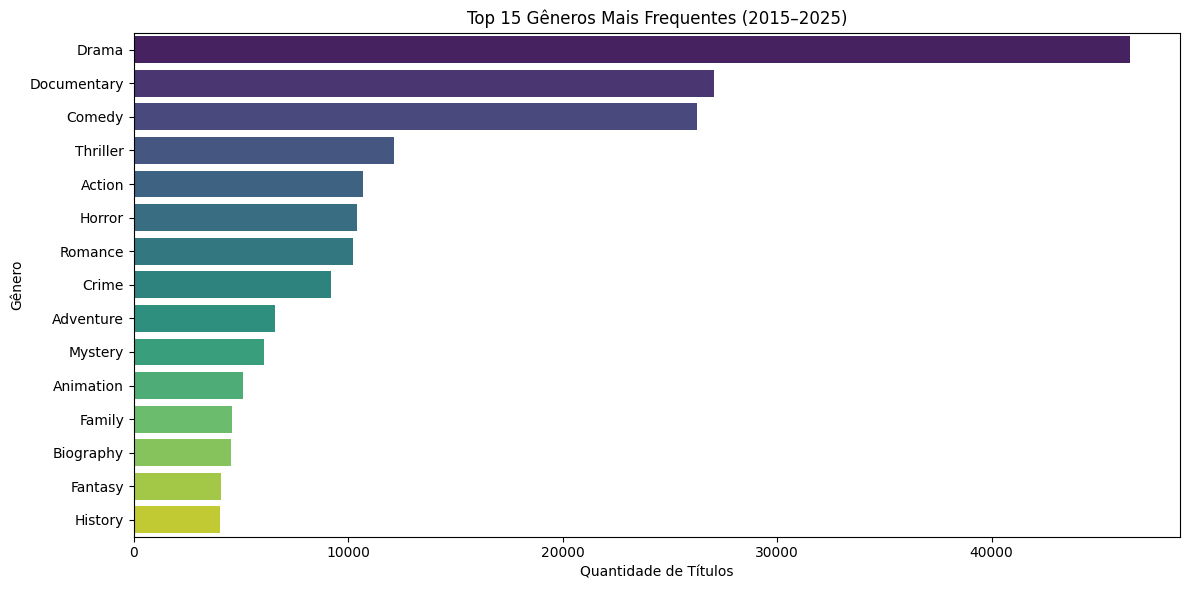

In [ ]:
# Explodir os gêneros em linhas separadas
df_generos = df.copy()
df_generos['genres'] = df_generos['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_exploded = df_generos.explode('genres')

# Contar frequência dos gêneros
genero_counts = df_exploded['genres'].value_counts().reset_index()
genero_counts.columns = ['Gênero', 'Quantidade']

# Plotar os 15 gêneros mais comuns
plt.figure(figsize=(12, 6))
sns.barplot(data=genero_counts.head(15), x='Quantidade', y='Gênero', palette='viridis')
plt.title('Top 15 Gêneros Mais Frequentes (2015–2025)')
plt.xlabel('Quantidade de Títulos')
plt.ylabel('Gênero')
plt.tight_layout()
plt.show()

### 6.3 Média de Avaliação por Ano

Vamos analisar como a avaliação média dos títulos evoluiu ao longo dos anos no período entre 2015 e 2025.

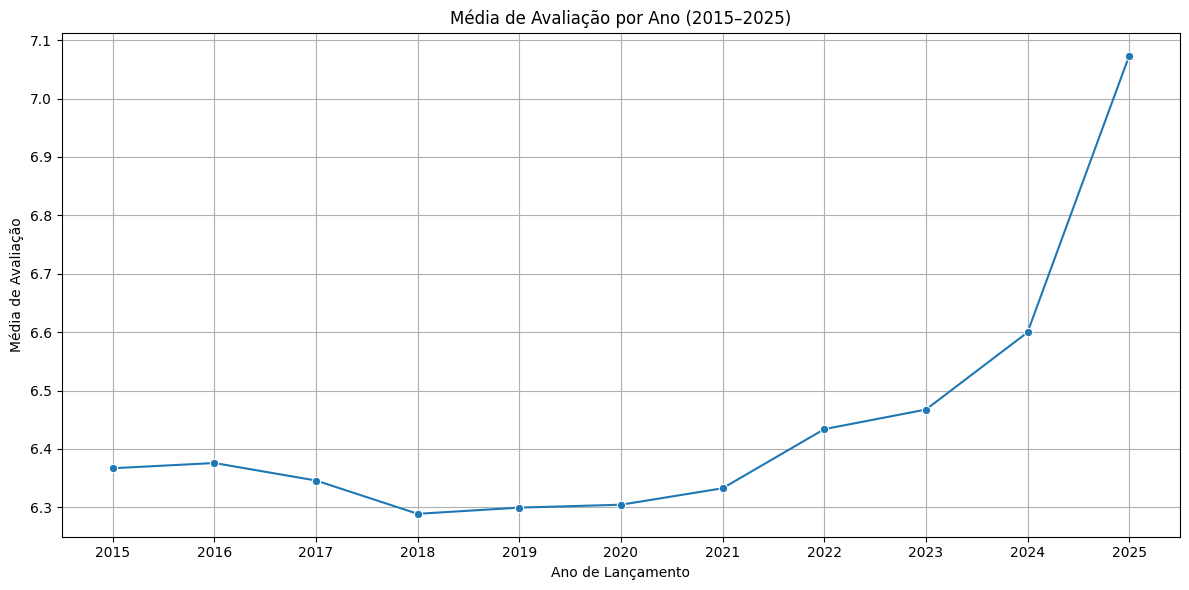

In [ ]:
# Calcular média de avaliação por ano
df_rating_year = df.groupby('startYear')['averageRating'].mean().reset_index()

# Plotar gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_rating_year, x='startYear', y='averageRating', marker='o')
plt.title('Média de Avaliação por Ano (2015–2025)')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Média de Avaliação')
plt.xticks(df_rating_year['startYear'])
plt.grid(True)
plt.tight_layout()
plt.show()

### 6.4 Duração Média por Gênero

Agora vamos explorar quanto tempo, em média, duram os títulos de cada gênero no período analisado. Essa métrica pode revelar padrões interessantes sobre o formato das produções mais populares.

<ipython-input-13-9d9495207457>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=duracao_media.head(15), x='Duração Média (min)', y='Gênero', palette='crest')


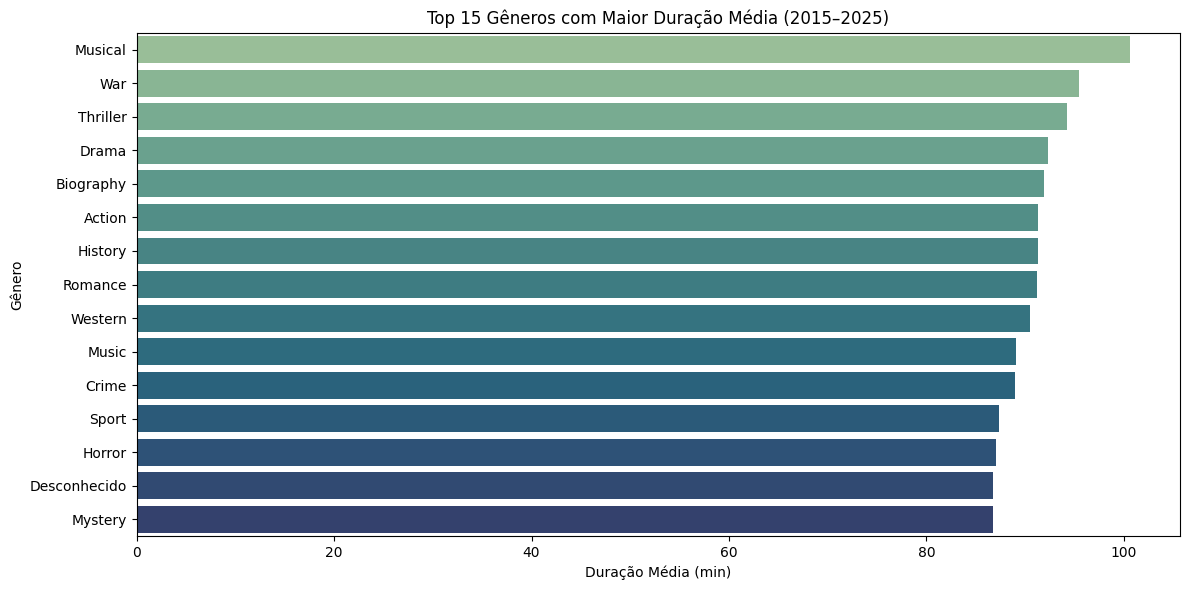

In [ ]:
# Garantir que os gêneros estejam formatados corretamente
df_generos_dur = df.copy()
df_generos_dur['genres'] = df_generos_dur['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_exploded_dur = df_generos_dur.explode('genres')

# Calcular duração média por gênero
duracao_media = df_exploded_dur.groupby('genres')['runtimeMinutes'].mean().reset_index()
duracao_media.columns = ['Gênero', 'Duração Média (min)']
duracao_media = duracao_media.sort_values(by='Duração Média (min)', ascending=False)

# Plotar
plt.figure(figsize=(12, 6))
sns.barplot(data=duracao_media.head(15), x='Duração Média (min)', y='Gênero', palette='crest')
plt.title('Top 15 Gêneros com Maior Duração Média (2015–2025)')
plt.xlabel('Duração Média (min)')
plt.ylabel('Gênero')
plt.tight_layout()
plt.show()

### 6.5 Diretores Mais Recorrentes

Agora vamos identificar os diretores mais frequentes no período de 2015 a 2025, considerando o número de títulos em que atuaram como diretores.

<ipython-input-14-83659a52600c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_diretores, x='Número de Títulos', y='Diretor', palette='flare')


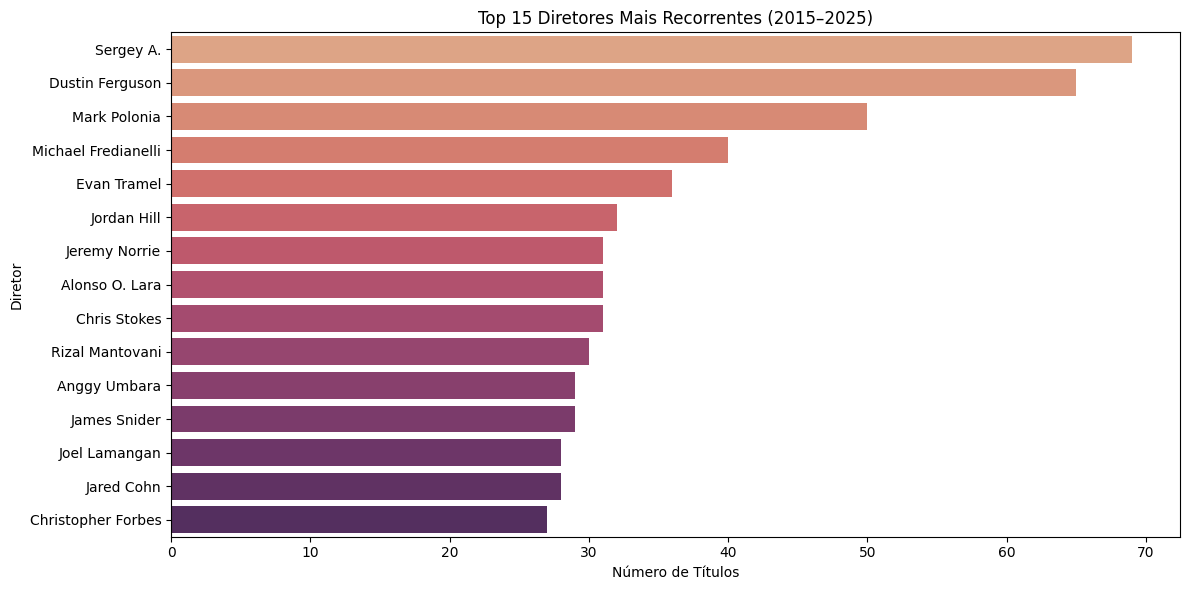

In [ ]:
# Explodir lista de diretores para contagem
df_diretores = df.copy()
df_exploded_diretores = df_diretores.explode('diretores')
df_exploded_diretores = df_exploded_diretores[df_exploded_diretores['diretores'].notnull() & (df_exploded_diretores['diretores'] != '')]

# Contar aparições por diretor
top_diretores = df_exploded_diretores['diretores'].value_counts().head(15).reset_index()
top_diretores.columns = ['Diretor', 'Número de Títulos']

# Plotar gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=top_diretores, x='Número de Títulos', y='Diretor', palette='flare')
plt.title('Top 15 Diretores Mais Recorrentes (2015–2025)')
plt.xlabel('Número de Títulos')
plt.ylabel('Diretor')
plt.tight_layout()
plt.show()

### 6.6 Atores Mais Recorrentes

Nesta análise, vamos identificar os atores e atrizes mais frequentes nas produções entre 2015 e 2025, considerando o número de títulos em que atuaram.

<ipython-input-15-7e4686758219>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_atores, x='Número de Títulos', y='Ator/Atriz', palette='rocket')


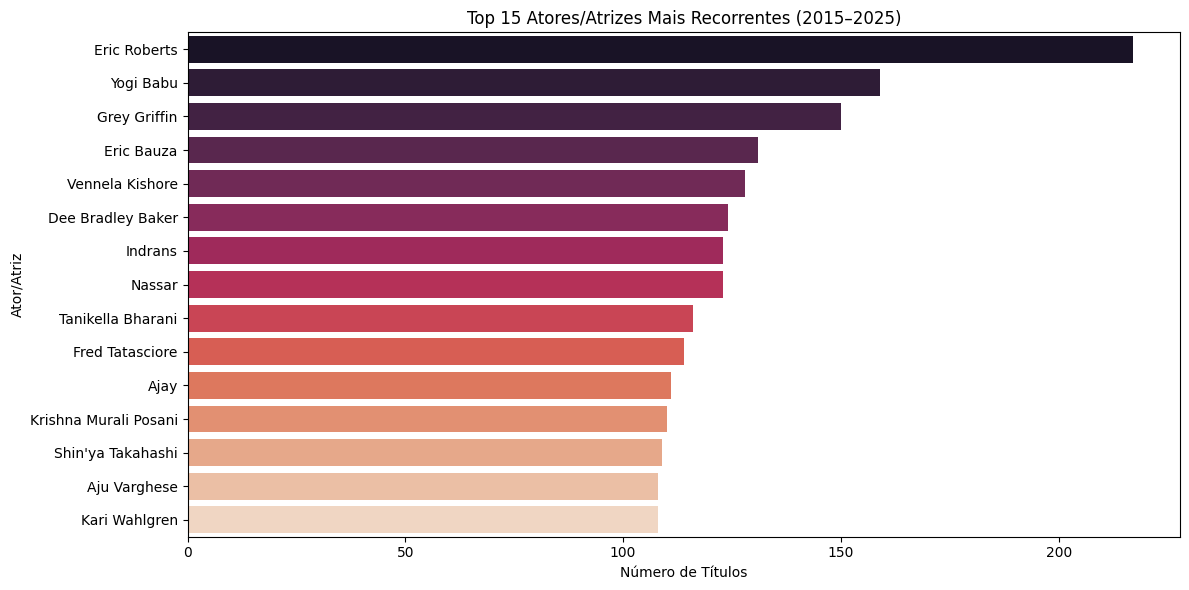

In [ ]:
# Explodir lista de atores para contagem
df_atores = df.copy()
df_exploded_atores = df_atores.explode('atores')
df_exploded_atores = df_exploded_atores[df_exploded_atores['atores'].notnull() & (df_exploded_atores['atores'] != '')]

# Contar aparições por ator
top_atores = df_exploded_atores['atores'].value_counts().head(15).reset_index()
top_atores.columns = ['Ator/Atriz', 'Número de Títulos']

# Plotar gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=top_atores, x='Número de Títulos', y='Ator/Atriz', palette='rocket')
plt.title('Top 15 Atores/Atrizes Mais Recorrentes (2015–2025)')
plt.xlabel('Número de Títulos')
plt.ylabel('Ator/Atriz')
plt.tight_layout()
plt.show()

### 6.7 Correlação entre Nota Média e Número de Votos

Vamos verificar se há uma correlação perceptível entre a avaliação média dos títulos e o número de votos recebidos. Essa análise ajuda a entender se títulos com maior visibilidade tendem a receber notas mais altas (ou mais baixas).

<ipython-input-16-9298e0d2fc97>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  faixa_avg = df.groupby('faixa_votos')['averageRating'].mean().reset_index()
<ipython-input-16-9298e0d2fc97>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=faixa_avg, x='faixa_votos', y='averageRating', palette='coolwarm')


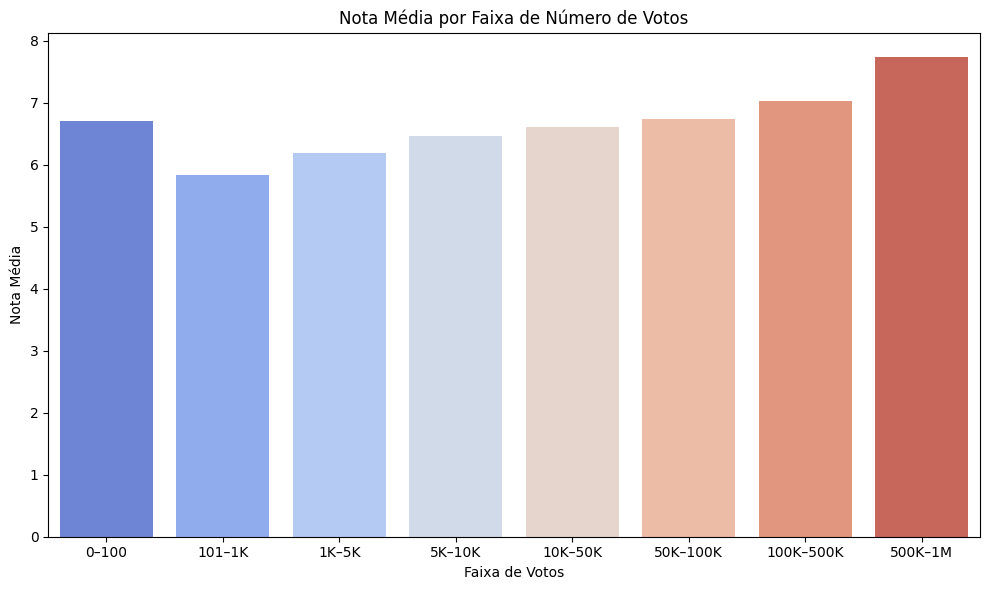

In [ ]:
# Definir faixas de número de votos
bins = [0, 100, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
labels = ['0–100', '101–1K', '1K–5K', '5K–10K', '10K–50K', '50K–100K', '100K–500K', '500K–1M']
df['faixa_votos'] = pd.cut(df['numVotes'], bins=bins, labels=labels)

# Calcular média por faixa
faixa_avg = df.groupby('faixa_votos')['averageRating'].mean().reset_index()

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=faixa_avg, x='faixa_votos', y='averageRating', palette='coolwarm')
plt.title('Nota Média por Faixa de Número de Votos')
plt.xlabel('Faixa de Votos')
plt.ylabel('Nota Média')
plt.tight_layout()
plt.show()

# 7 - Conclusão

Neste projeto, analisamos dados do IMDb entre 2015 e 2025, com foco em tendências de lançamentos, gêneros, duração, avaliações e frequência de diretores e atores. Entre os principais achados:

- **Crescimento ou estabilidade** na produção de filmes e séries ao longo da década
- **Gêneros como Drama, Documentário e Comédia** dominaram o volume de títulos
- **Minisséries** tendem a ter durações médias mais altas
- Alguns diretores e atores aparecem com frequência impressionante, indicando grande atividade ou popularidade
- Existe uma **correlação leve positiva** entre o número de votos e a nota média — títulos mais votados tendem a manter boas avaliações, mas há muita variação

Esse estudo pode ser estendido com mais análises por país, idioma, plataforma ou cruzando com dados de receita e premiações.